# Step 1. Cleaning and Preprocessing

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, lower, regexp_replace, trim, initcap, udf, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, NaiveBayes,LinearSVC, OneVsRest, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StringType
import time
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from sklearn.metrics import classification_report, f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import time

In [2]:
!pip install pyngrok
import string
from pyspark.sql import SparkSession
from pyngrok import ngrok

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Initialize Spark session
spark = SparkSession.builder.appName("Airbnb Data Cleaning").getOrCreate()

# Load the dataset
file_path = "/content/AB_NYC_2019.csv"
airbnb_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Displaying the schema
airbnb_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: integer (nullable = true)



In [5]:
duplicate_count_before = airbnb_df.count() - airbnb_df.dropDuplicates().count()
print(f"Number of duplicate rows before dropping: {duplicate_count_before}")

# Dropping duplicates
airbnb_df = airbnb_df.dropDuplicates()

# Checking for duplicates after dropping
duplicate_count_after = airbnb_df.count() - airbnb_df.dropDuplicates().count()
print(f"Number of duplicate rows after dropping: {duplicate_count_after}")


Number of duplicate rows before dropping: 1
Number of duplicate rows after dropping: 0


In [6]:
# Converting numeric columns from string to appropriate types
airbnb_df = airbnb_df.withColumn("price", col("price").cast("float"))
airbnb_df = airbnb_df.withColumn("minimum_nights", col("minimum_nights").cast("int"))
airbnb_df = airbnb_df.withColumn("number_of_reviews", col("number_of_reviews").cast("int"))
airbnb_df = airbnb_df.withColumn("reviews_per_month", col("reviews_per_month").cast("float"))
airbnb_df = airbnb_df.withColumn("calculated_host_listings_count", col("calculated_host_listings_count").cast("double"))
airbnb_df = airbnb_df.withColumn("availability_365", col("availability_365").cast("double"))
airbnb_df = airbnb_df.withColumn("latitude", col("latitude").cast("double"))
airbnb_df = airbnb_df.withColumn("longitude", col("longitude").cast("double"))


In [7]:
# Counting missing values in 'name' column
name_missing_count = airbnb_df.filter(col("name").isNull()).count()
airbnb_df = airbnb_df.withColumn("name", when(col("name").isNull(), "No Name Provided").otherwise(col("name")))
print(f"Filled {name_missing_count} missing values in 'name' column.")

# Counting missing values in 'host_name' column
host_name_missing_count = airbnb_df.filter(col("host_name").isNull()).count()
airbnb_df = airbnb_df.withColumn("host_name", when(col("host_name").isNull(), "Unknown Host").otherwise(col("host_name")))
print(f"Filled {host_name_missing_count} missing values in 'host_name' column.")


Filled 31 missing values in 'name' column.
Filled 205 missing values in 'host_name' column.


In [8]:
# Counting missing values in 'last_review' and filling with  default value
last_review_missing_count = airbnb_df.filter(col("last_review").isNull()).count()
airbnb_df = airbnb_df.withColumn("last_review", when(col("last_review").isNull(), lit("2000-01-01")).otherwise(col("last_review")))
print(f"Filled {last_review_missing_count} missing values in 'last_review' column with default date '1900-01-01'.")


Filled 10233 missing values in 'last_review' column with default date '1900-01-01'.


In [9]:
# Counting and filling missing values in 'reviews_per_month'
reviews_per_month_missing_count = airbnb_df.filter(col("reviews_per_month").isNull()).count()
airbnb_df = airbnb_df.withColumn("reviews_per_month", when(col("reviews_per_month").isNull(), 0).otherwise(col("reviews_per_month")))
print(f"Filled {reviews_per_month_missing_count} missing values in 'reviews_per_month' column with 0.")


Filled 10220 missing values in 'reviews_per_month' column with 0.


In [10]:
# Converting and filling missing values for 'price' with the median value
median_price = airbnb_df.approxQuantile("price", [0.5], 0.05)[0]
price_missing_count = airbnb_df.filter(col("price").isNull()).count()
airbnb_df = airbnb_df.withColumn("price", when(col("price").isNull(), median_price).otherwise(col("price")))
print(f"Filled {price_missing_count} missing values in 'price' column with median value {median_price}.")


Filled 191 missing values in 'price' column with median value 100.0.


In [11]:
# Display the first 20 rows without truncating column values
airbnb_df.show(truncate=False)


+-------+------------------------------------------------+--------+-------------------+-------------------+-------------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|id     |name                                            |host_id |host_name          |neighbourhood_group|neighbourhood            |latitude|longitude|room_type      |price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+-------+------------------------------------------------+--------+-------------------+-------------------+-------------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|66275  |Lower East Side Magic Room                      |314941  |Tony               |Manhattan          |Lower East Side          |40.71904|

In [12]:
#feature binning

# Define bins for 'price'
airbnb_df = airbnb_df.withColumn(
    "price_category",
    when(col("price") <= 100, "Low")
    .when((col("price") > 100) & (col("price") <= 300), "Medium")
    .otherwise("High")
)
# Define bins for 'reviews_per_month'
airbnb_df = airbnb_df.withColumn(
    "reviews_category",
    when(col("reviews_per_month") <= 1, "Rarely Reviewed")
    .when((col("reviews_per_month") > 1) & (col("reviews_per_month") <= 3), "Moderately Reviewed")
    .otherwise("Frequently Reviewed")
)
print("Feature binning completed.")
airbnb_df.select("price", "price_category", "reviews_per_month", "reviews_category").show(20)

Feature binning completed.
+-----+--------------+-----------------+-------------------+
|price|price_category|reviews_per_month|   reviews_category|
+-----+--------------+-----------------+-------------------+
| 95.0|           Low|             1.11|Moderately Reviewed|
|110.0|        Medium|             0.39|    Rarely Reviewed|
|100.0|           Low|             1.61|Moderately Reviewed|
|145.0|        Medium|             2.62|Moderately Reviewed|
| 90.0|           Low|             0.46|    Rarely Reviewed|
|149.0|        Medium|             0.14|    Rarely Reviewed|
| 80.0|           Low|              0.4|    Rarely Reviewed|
|130.0|        Medium|             0.03|    Rarely Reviewed|
|135.0|        Medium|             0.62|    Rarely Reviewed|
| 55.0|           Low|             0.14|    Rarely Reviewed|
|109.0|        Medium|             0.19|    Rarely Reviewed|
|200.0|        Medium|             0.05|    Rarely Reviewed|
|200.0|        Medium|             0.82|    Rarely Reviewe

In [13]:
# Filter out listings with invalid 'price' or 'minimum_nights'
airbnb_df = airbnb_df.filter((col("price") > 0) & (col("minimum_nights") > 0))

# Filter out listings where 'availability_365' is 0 but 'reviews_per_month' > 0
airbnb_df = airbnb_df.filter(~((col("availability_365") == 0) & (col("reviews_per_month") > 0)))

# Show remaining rows after filtering
print("Inconsistent data removed.")
airbnb_df.show(20)

Inconsistent data removed.
+-------+--------------------+--------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+
|     id|                name| host_id|          host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|   reviews_category|
+-------+--------------------+--------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+
|  66275|Lower East Side M...|  314941|               Tony|          Manhattan|     Lower East Side|40.71904|

In [14]:
airbnb_df.show(10)

+-------+--------------------+--------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+
|     id|                name| host_id|          host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|   reviews_category|
+-------+--------------------+--------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+
|  66275|Lower East Side M...|  314941|               Tony|          Manhattan|     Lower East Side|40.71904|-73.99392|   Private room| 

In [15]:
# Text preprocessing, removing uncessary punctuations or characters from name column

def clean_text(df):
  # Remove unwanted characters (such as !+*.#) same as phase 1 cleaning
  df = df.withColumn("name_cleaned",regexp_replace(col("name"), r'[!.,?;:]+', ''))
  df = df.withColumn("name_cleaned", trim(col("name_cleaned")))

  return df

# call the clean text function
airbnb_df = clean_text(airbnb_df)

In [16]:
airbnb_df.select('name_cleaned').show(truncate=False)

+------------------------------------------------+
|name_cleaned                                    |
+------------------------------------------------+
|Lower East Side Magic Room                      |
|STUDIO APT 1 IN PROSPECT LEFFERTS GARDENS       |
|Charming Apt In Brooklyn Townhouse              |
|Cozy 2 BR apartment in Queens                   |
|Habitat 101 Amazing 1br Loft Apartment          |
|Charming LG Bedroom by Park & Train             |
|Beautiful Luxury Room in Central Harlem/Columbia|
|Spacious 1 bed near train                       |
|West Village designer studio                    |
|Cozy Vintage Artist Flat(Williamsburg/Bushwick) |
|Garden Apartment with private patio in Townhouse|
|Private Room A                                  |
|Vintage Room  in  Brooklyn                      |
|Spacious rustic barn style bedroom              |
|This cozy space is a newly renovate             |
|Fab Park Slope garden apt w/ patio              |
|Spacious European Room for ren

In [17]:
#standarzie the string columns
string_columns = ['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price_category','reviews_category', 'name_cleaned']

for column in string_columns:
  #covert to title case and remove trainling spaces
  airbnb_df = airbnb_df.withColumn(column, initcap(trim(col(column))))

# Show the resulting DataFrame
airbnb_df.show(truncate=False)

+-------+------------------------------------------------+--------+-------------------+-------------------+-------------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+------------------------------------------------+
|id     |name                                            |host_id |host_name          |neighbourhood_group|neighbourhood            |latitude|longitude|room_type      |price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|reviews_category   |name_cleaned                                    |
+-------+------------------------------------------------+--------+-------------------+-------------------+-------------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+-----------------------

In [18]:
#aggregating data based on host_id and average price and number of reviews
#can be used for regression aanlysis and predicting markeitng/pricing strategies and data for specific hosts

host_aggregated_df = airbnb_df.groupBy('host_id').agg(
  F.avg('price').alias('avg_price'),
  F.sum('number_of_reviews').alias('total_reviews'),
)

airbnb_df = airbnb_df.join(host_aggregated_df, on='host_id', how='left')

airbnb_df.show()

+--------+-------+--------------------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+--------------------+------------------+-------------+
| host_id|     id|                name|          host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|   reviews_category|        name_cleaned|         avg_price|total_reviews|
+--------+-------+--------------------+-------------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+--------------------+--------

In [19]:
# create rank listings and order by price for each neighborhood
#help group pricing within the neighbourhoods in order
grouping = Window.partitionBy('neighbourhood').orderBy(F.desc('price'))

# rank of each listing within its neighborhood
airbnb_df = airbnb_df.withColumn('price_rank', F.row_number().over(grouping))

airbnb_df.show(30)


+---------+--------+--------------------+--------------------+-------------------+-------------+--------+---------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+--------------------+---------+-------------+----------+
|  host_id|      id|                name|           host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type| price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|   reviews_category|        name_cleaned|avg_price|total_reviews|price_rank|
+---------+--------+--------------------+--------------------+-------------------+-------------+--------+---------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+--------------------+---------+---

In [20]:
#adding room_type encoding of pyspark to categorize room_type, neighbouthood_group to use in models later

room_type_indexer = StringIndexer(inputCol='room_type', outputCol='room_type_index')
airbnb_df = room_type_indexer.fit(airbnb_df).transform(airbnb_df)

neighbourhood_indexer = StringIndexer(inputCol="neighbourhood_group", outputCol="neighbourhood_group_index")
airbnb_df = neighbourhood_indexer.fit(airbnb_df).transform(airbnb_df)

airbnb_df.groupBy("room_type_index").count().show()
airbnb_df.groupBy("neighbourhood_group_index").count().show()

+---------------+-----+
|room_type_index|count|
+---------------+-----+
|            0.0|18728|
|            1.0|16346|
|            2.0|  975|
|            3.0|    1|
|            6.0|    1|
|            7.0|    1|
|            8.0|    1|
|            4.0|    1|
|            5.0|    1|
+---------------+-----+

+-------------------------+-----+
|neighbourhood_group_index|count|
+-------------------------+-----+
|                      0.0|15777|
|                      1.0|14274|
|                      4.0|  343|
|                      3.0|  959|
|                      2.0| 4696|
|                      5.0|    1|
|                      9.0|    1|
|                     10.0|    1|
|                      8.0|    1|
|                      7.0|    1|
|                      6.0|    1|
+-------------------------+-----+



In [21]:
# Print the schema of the DataFrame to check the data types of all columns
airbnb_df.printSchema()


root
 |-- host_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: double (nullable = true)
 |-- price_category: string (nullable = false)
 |-- reviews_category: string (nullable = false)
 |-- name_cleaned: string (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- total_reviews: long (nullable = true)
 |-- price_rank: integer (nullable = false)
 |-- room_type_index: do

In [22]:
#checking the different neighbourhoods
values = airbnb_df.groupBy('neighbourhood_group').count()
values.show()

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|             Queens| 4696|
|           Brooklyn|14274|
|      Staten Island|  343|
|          Manhattan|15777|
|              Bronx|  959|
|             Carmen|    1|
|               Seth|    1|
|      William Hakan|    1|
|              Nadia|    1|
|             Evelyn|    1|
|             Krista|    1|
+-------------------+-----+



In [23]:
#drop row where the neighbourhood group not in the five: Queens, Brooklyn, Staten Island, Manhattan and Bronx
valid_groups = ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']

airbnb_df = airbnb_df.filter(airbnb_df.neighbourhood_group.isin(valid_groups))

airbnb_df.groupBy("neighbourhood_group").count().show()
# airbnb_df.show(truncate=False)

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|             Queens| 4696|
|           Brooklyn|14274|
|      Staten Island|  343|
|          Manhattan|15777|
|              Bronx|  959|
+-------------------+-----+



In [24]:
#checking the different neighbourhoods and  making sure its just the 5 from valid groups
values = airbnb_df.groupBy('neighbourhood_group').count()
values.show()

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|             Queens| 4696|
|           Brooklyn|14274|
|      Staten Island|  343|
|          Manhattan|15777|
|              Bronx|  959|
+-------------------+-----+



In [25]:
#checking the outlier values
print("Before Handling Outliers:")
airbnb_df.describe("price").show()

Before Handling Outliers:
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             36049|
|   mean| 161.8760575882826|
| stddev|252.50484136554908|
|    min|              10.0|
|    max|           10000.0|
+-------+------------------+



In [26]:
#Handling outliers for price column

quantiles = airbnb_df.approxQuantile("price", [0.25, 0.75], 0.01)

q1, q3 = quantiles[0], quantiles[1]
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter outliers and update the DataFrame
airbnb_df = airbnb_df.filter((col("price") >= lower_bound) & (col("price") <= upper_bound))

In [27]:
#making sure outliers is fixed
print("After Handling Outliers:")
airbnb_df.describe("price").show()

After Handling Outliers:
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             33833|
|   mean|125.21295776313067|
| stddev| 73.88586887726281|
|    min|              10.0|
|    max|             350.0|
+-------+------------------+



# Step 2: Machine Learning Models

In [28]:
#1 #decision tree

start_time = time.time()

assembler = VectorAssembler(
    inputCols=["neighbourhood_group_index", "calculated_host_listings_count", "availability_365"],
    outputCol="assembled_features"
)
dt = DecisionTreeClassifier(labelCol="room_type_index", featuresCol="assembled_features")
pipeline = Pipeline(stages=[assembler, dt])
train_data, test_data = airbnb_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="room_type_index", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score_dt = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

execution_time = time.time() - start_time
print(f"Decision Tree Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score_dt:.2f}")
print(f"Execution Time: {execution_time:.2f} seconds")
predictions.select("assembled_features", "room_type_index", "prediction").show()

Decision Tree Classifier Metrics:
Accuracy: 0.63
Precision: 0.61
Recall: 0.63
F1 Score: 0.62
Execution Time: 9.04 seconds
+------------------+---------------+----------+
|assembled_features|room_type_index|prediction|
+------------------+---------------+----------+
|   [0.0,1.0,351.0]|            0.0|       0.0|
|    [1.0,1.0,89.0]|            1.0|       0.0|
|     [0.0,1.0,0.0]|            0.0|       0.0|
|    [3.0,1.0,26.0]|            0.0|       1.0|
|   [1.0,1.0,343.0]|            1.0|       0.0|
|    [0.0,1.0,26.0]|            1.0|       0.0|
|     [0.0,1.0,0.0]|            1.0|       0.0|
|    [2.0,1.0,56.0]|            1.0|       1.0|
|   [0.0,3.0,358.0]|            0.0|       1.0|
|   [2.0,4.0,353.0]|            1.0|       1.0|
|   [2.0,4.0,349.0]|            1.0|       1.0|
|   [2.0,4.0,346.0]|            1.0|       1.0|
|   [0.0,2.0,316.0]|            1.0|       1.0|
|   [3.0,1.0,348.0]|            1.0|       0.0|
|     [0.0,1.0,0.0]|            1.0|       0.0|
|   [2.0,3.0,1

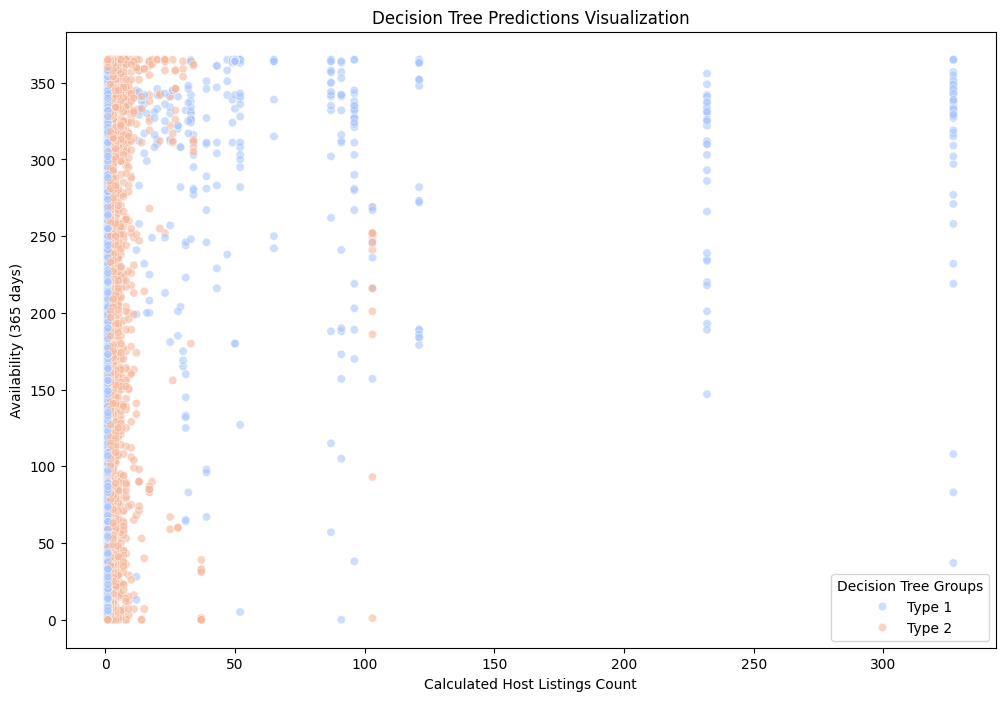

In [29]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
df_decision_tree = predictions.select(
    "neighbourhood_group_index", "calculated_host_listings_count", "availability_365", "prediction", "room_type_index"
).toPandas()

decision_tree_label_mapping = {
    0.0: "Type 1",
    1.0: "Type 2",
}
df_decision_tree["category"] = df_decision_tree["prediction"].map(decision_tree_label_mapping)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_decision_tree,
    x="calculated_host_listings_count",
    y="availability_365",
    hue="category",
    palette="coolwarm",
    alpha=0.6
)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title="Decision Tree Groups")
plt.title("Decision Tree Predictions Visualization")
plt.xlabel("Calculated Host Listings Count")
plt.ylabel("Availability (365 days)")
plt.show()

In [30]:
airbnb_df.show()

+---------+--------+--------------------+--------------------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------------+-------------------+--------------------+---------+-------------+----------+---------------+-------------------------+
|  host_id|      id|                name|           host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|price_category|   reviews_category|        name_cleaned|avg_price|total_reviews|price_rank|room_type_index|neighbourhood_group_index|
+---------+--------+--------------------+--------------------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+-----

1732574057.7098608
Logistic Regression Accuracy: 0.81
F1-Score: 0.80
Precision: 0.85
Recall: 0.75
Execution Time: 10.98 seconds
Classification Report:

                     precision    recall  f1-score   support

Not Entire Home/Apt       0.78      0.87      0.82      3334
    Entire Home/Apt       0.85      0.75      0.80      3302

           accuracy                           0.81      6636
          macro avg       0.81      0.81      0.81      6636
       weighted avg       0.81      0.81      0.81      6636



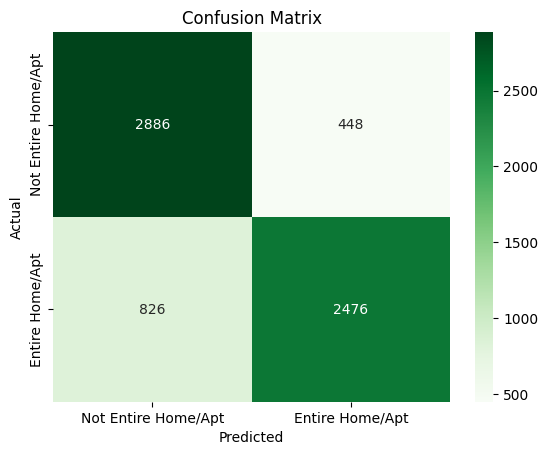

In [31]:
#2. Logistic Regression
start_time = time.time()
print(start_time)

# Create the binary Labels Entire Apt/Not Entire Apartment
airbnb_df = airbnb_df.withColumn(
  "room_binary", when(col("room_type_index") == 0, 1).otherwise(0))

# Assemble Features
feature_cols_lr = ['neighbourhood_group_index', 'price']
assembler = VectorAssembler(inputCols=feature_cols_lr, outputCol="features_lr")
df = assembler.transform(airbnb_df)

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)  #80% train and 20% test

lr = LogisticRegression(featuresCol="features_lr", labelCol="room_binary", maxIter=1000,regParam=0.01,elasticNetParam=0.0)
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="room_binary", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Logistic Regression Accuracy: {accuracy:.2f}")

# Manually computing the  Precision, Recall, F1 Score for class 1 (Entire Home/Apt)
true_p = predictions.filter((col("room_binary") == 1) & (col("prediction") == 1)).count()
false_p = predictions.filter((col("room_binary") == 0) & (col("prediction") == 1)).count()
false_n = predictions.filter((col("room_binary") == 1) & (col("prediction") == 0)).count()
true_n = predictions.filter((col("room_binary") == 0) & (col("prediction") == 0)).count()

precision = true_p / (true_p + false_p) if (true_p + false_p) > 0 else 0
recall = true_p / (true_p + false_n) if (true_p + false_n) > 0 else 0
f1_score_lr = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Execution time
execution_time = time.time() - start_time

print(f"F1-Score: {f1_score_lr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Execution Time: {execution_time:.2f} seconds")

predictions_pd = predictions.select("room_binary", "prediction").toPandas()

y_true_lr = predictions_pd["room_binary"]
y_pred_lr = predictions_pd["prediction"]

# display the classification report
class_report_lr = classification_report(y_true_lr, y_pred_lr, target_names=["Not Entire Home/Apt", "Entire Home/Apt"])
print("Classification Report:\n")
print(class_report_lr)

# Confusion Matrix
conf_matrix = predictions.select("room_binary", "prediction").groupBy(
    "room_binary", "prediction").count().toPandas()

# Using pivot to create confusion matrix
conf_matrix = conf_matrix.pivot(index="room_binary", columns="prediction", values="count").fillna(0)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Not Entire Home/Apt", "Entire Home/Apt"],
            yticklabels=["Not Entire Home/Apt", "Entire Home/Apt"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

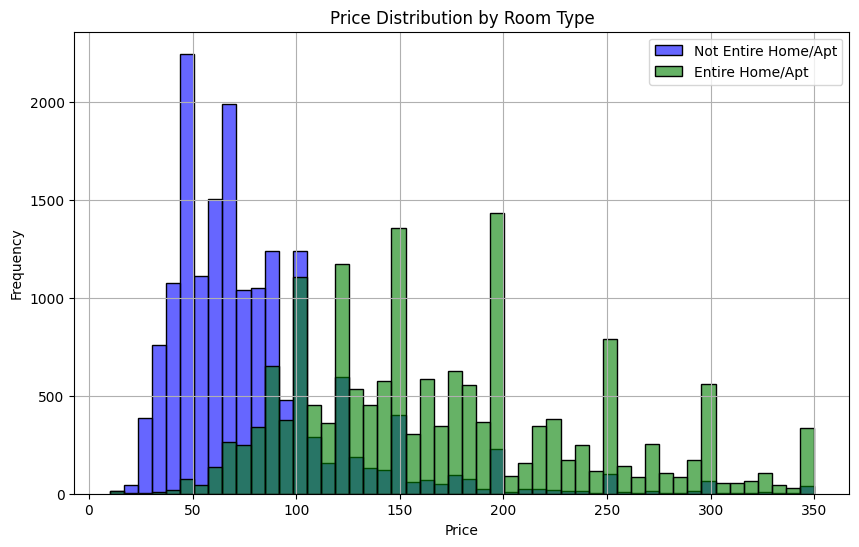

In [32]:
plot_data = airbnb_df.select("room_binary", "price", "neighbourhood_group_index").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data[plot_data['room_binary'] == 0], x="price", bins=50, color="blue", alpha=0.6, label="Not Entire Home/Apt")
sns.histplot(data=plot_data[plot_data['room_binary'] == 1], x="price", bins=50, color="green", alpha=0.6, label="Entire Home/Apt")
plt.title("Price Distribution by Room Type")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()


In [33]:
#3 K-Means Clustering
start_time = time.time()
# Assemble features for clustering
assembler = VectorAssembler(inputCols=['price'], outputCol='price_vector')
df_vector = assembler.transform(df)

# Scale the features
scaler = MinMaxScaler(inputCol='price_vector', outputCol='scaled_price')
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)
execution_time = time.time() - start_time
# Train K-means model with k=3
kmeans = KMeans(featuresCol='scaled_price', k=3, seed=42)
model = kmeans.fit(df_scaled)

# Predict clusters
df_clusters = model.transform(df_scaled)

# Map cluster numbers to human-readable labels
centers = model.clusterCenters()
sorted_centers = sorted((value[0], index) for index, value in enumerate(centers))
cluster_labels = {sorted_centers[0][1]: 'Affordable',
                  sorted_centers[1][1]: 'Mid-Range',
                  sorted_centers[2][1]: 'Luxurious'}

# Define a UDF for labeling
label_udf = udf(lambda x: cluster_labels[x], StringType())

# Add cluster labels to DataFrame
df_final = df_clusters.withColumn("price_category", label_udf(df_clusters["prediction"]))

# Show the final DataFrame
df_final.select('id', 'name', 'price', 'prediction', 'price_category').show()
print(f"Execution Time: {execution_time:.2f} seconds")


# Silhouette Score evaluation
evaluator = ClusteringEvaluator(featuresCol='scaled_price', predictionCol='prediction', metricName='silhouette')
silhouette_score = evaluator.evaluate(df_clusters)
print(f"Silhouette Score: {silhouette_score:.4f}")


+-------+--------------------+-----+----------+--------------+
|     id|                name|price|prediction|price_category|
+-------+--------------------+-----+----------+--------------+
|  66275|Lower East Side M...| 95.0|         2|    Affordable|
| 944755|Studio Apt 1. In ...|100.0|         2|    Affordable|
| 997404|Charming Apt. In ...|145.0|         0|     Mid-Range|
|1220548|Cozy 2 Br Apartme...| 90.0|         2|    Affordable|
|1656254|Habitat 101. Amaz...|149.0|         0|     Mid-Range|
|1677887|Charming Lg Bedro...| 80.0|         2|    Affordable|
|1945115|Beautiful Luxury ...| 90.0|         2|    Affordable|
|1981410|Spacious 1 Bed Ne...|135.0|         0|     Mid-Range|
|3268008|West Village Desi...|200.0|         0|     Mid-Range|
|3674757|Cozy Vintage Arti...| 77.0|         2|    Affordable|
|3704067|Garden Apartment ...|175.0|         0|     Mid-Range|
|4060526|      Private Room A| 39.0|         2|    Affordable|
|4586880|Vintage Room  In ...| 50.0|         2|    Affo

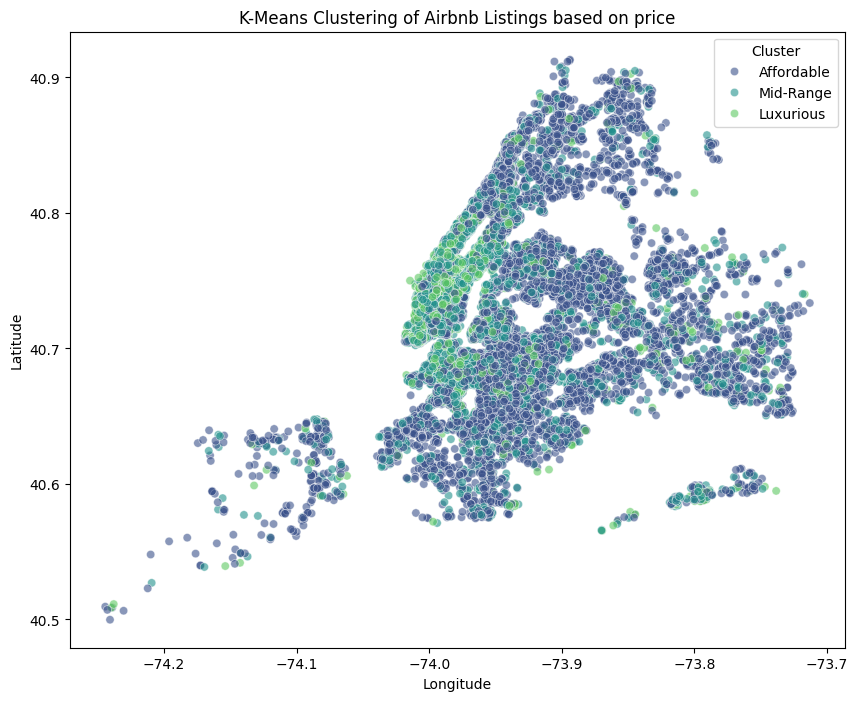

In [34]:
df_pandas = df_final.select('id', 'name', 'price', 'longitude','latitude', 'prediction', 'price_category').toPandas()

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df_pandas,
    x='longitude',
    y='latitude',
    hue='price_category',
    palette='viridis',
    alpha=0.6
)

# Customize legend and labels
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title='Cluster')
plt.title('K-Means Clustering of Airbnb Listings based on price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [35]:
#4 Random Forest Classification
# Index the 'price_category' column if it is a string
price_indexer = StringIndexer(inputCol="price_category", outputCol="price_category_index")
airbnb_df = price_indexer.fit(airbnb_df).transform(airbnb_df)

# Assemble features for Random Forest
assembler = VectorAssembler(inputCols=['latitude', 'longitude', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'],
                            outputCol='features_rf')
df_features = assembler.transform(airbnb_df)

# Split the data into training and test sets
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

# Measure execution time for model training
start_time = time.time()

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(labelCol='price_category_index', featuresCol='features_rf', numTrees=100, seed=42)
rf_model = rf.fit(train_df)

# Measure execution time
execution_time = time.time() - start_time

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='price_category_index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Calculate additional metrics if ground truth exists
y_true = predictions.select('price_category_index').toPandas()['price_category_index']
y_pred = predictions.select('prediction').toPandas()['prediction']
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_rf = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")

# Also change the variable name here:
print(classification_report(y_true, y_pred, target_names=['Affordable', 'Mid-Range', 'Luxurious'], zero_division=0))

# Print a few predictions
predictions.select('latitude', 'longitude', 'price_category', 'prediction').show(20)

Execution Time: 5.39 seconds
Random Forest Classifier Accuracy: 0.6967

Classification Report:
              precision    recall  f1-score   support

  Affordable       0.69      0.79      0.74      3357
   Mid-Range       0.71      0.63      0.67      3136
   Luxurious       0.00      0.00      0.00       143

    accuracy                           0.70      6636
   macro avg       0.47      0.47      0.47      6636
weighted avg       0.68      0.70      0.69      6636

+--------+---------+--------------+----------+
|latitude|longitude|price_category|prediction|
+--------+---------+--------------+----------+
|40.74768|-73.98723|        Medium|       1.0|
|40.68409|-73.96467|           Low|       1.0|
|40.76435|-73.99054|        Medium|       1.0|
|40.83844|-73.92489|           Low|       0.0|
|40.63255|-73.97324|           Low|       0.0|
|40.76525|-73.98058|        Medium|       1.0|
|40.76148|-73.99489|          High|       1.0|
|40.71515| -73.8158|           Low|       0.0|
|40.767

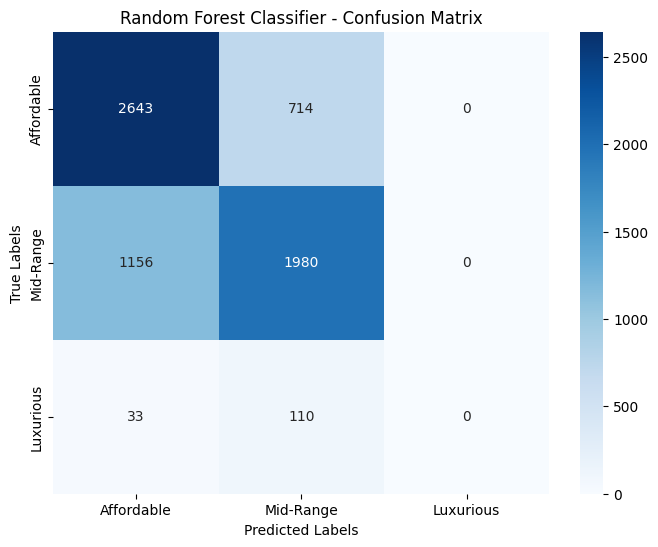

In [36]:
# Convert predictions to a Pandas DataFrame
predictions_pandas = predictions.select('price_category_index', 'prediction').toPandas()

# Generate a confusion matrix
cm = confusion_matrix(
    predictions_pandas['price_category_index'],
    predictions_pandas['prediction']
)

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Affordable', 'Mid-Range', 'Luxurious'], yticklabels=['Affordable', 'Mid-Range', 'Luxurious'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Classifier - Confusion Matrix')
plt.show()


In [37]:
#5 SVM

start_time = time.time()

assembler = VectorAssembler(
    inputCols=["latitude", "longitude", "price", "reviews_per_month", "neighbourhood_group_index"],
    outputCol="features"
)
airbnb_df = assembler.transform(airbnb_df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(airbnb_df)
airbnb_df = scaler_model.transform(airbnb_df)
train_data_svm, test_data = airbnb_df.randomSplit([0.8, 0.2], seed=42)
svm = LinearSVC(featuresCol="scaled_features", labelCol="room_type_index", maxIter=10, regParam=0.1)
ovr = OneVsRest(classifier=svm, labelCol="room_type_index")
ovr_model = ovr.fit(train_data_svm)
predictions = ovr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="room_type_index",predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score_svm = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
execution_time = time.time() - start_time

print(f"Multi-class SVM Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score_svm:.2f}")
print(f"Execution Time: {execution_time:.2f} seconds")
predictions.select("features", "room_type_index", "prediction").show()

Multi-class SVM Metrics:
Accuracy: 0.77
Precision: 0.76
Recall: 0.77
F1 Score: 0.76
Execution Time: 69.30 seconds
+--------------------+---------------+----------+
|            features|room_type_index|prediction|
+--------------------+---------------+----------+
|[40.74768,-73.987...|            0.0|       0.0|
|[40.68409,-73.964...|            1.0|       1.0|
|[40.76435,-73.990...|            0.0|       0.0|
|[40.83844,-73.924...|            0.0|       1.0|
|[40.63255,-73.973...|            1.0|       1.0|
|[40.76525,-73.980...|            1.0|       0.0|
|[40.76148,-73.994...|            1.0|       0.0|
|[40.71515,-73.815...|            1.0|       1.0|
|[40.76704,-73.986...|            0.0|       0.0|
|[40.77214,-73.891...|            1.0|       1.0|
|[40.77309,-73.892...|            1.0|       1.0|
|[40.77224,-73.892...|            1.0|       0.0|
|[40.76492,-73.991...|            1.0|       0.0|
|[40.83464,-73.925...|            1.0|       1.0|
|[40.75403,-73.971...|            1.

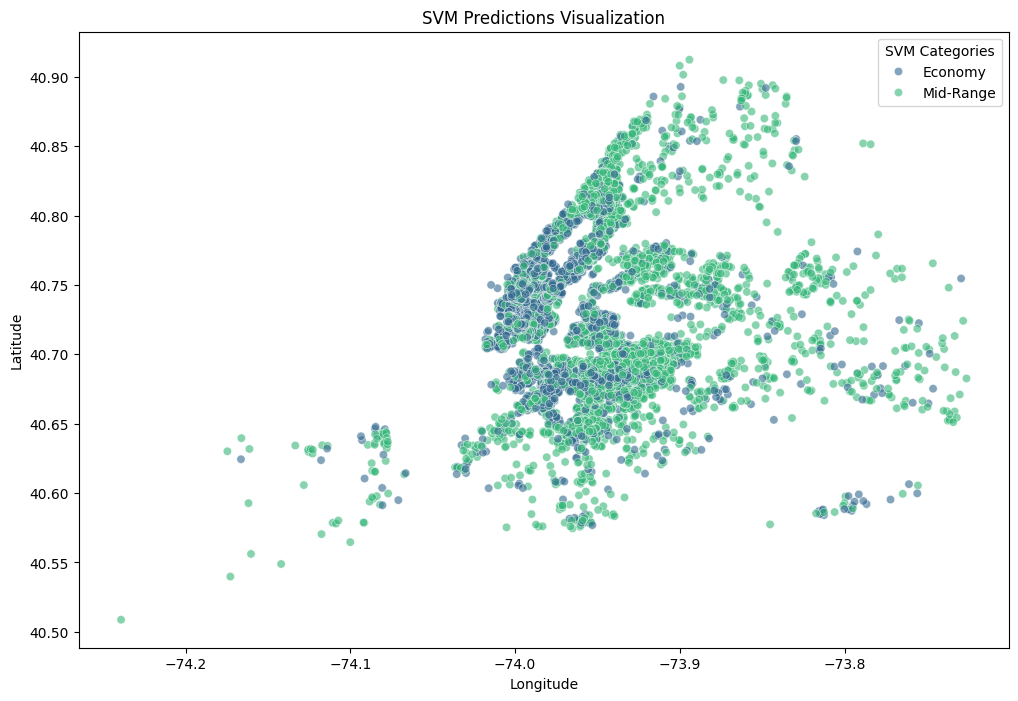

In [38]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
df_svm = predictions.select(
    "latitude", "longitude", "price", "reviews_per_month", "prediction", "room_type_index"
).toPandas()

svm_label_mapping = {
    0.0: "Economy",
    1.0: "Mid-Range",
    2.0: "Luxury"
}
df_svm["category"] = df_svm["prediction"].map(svm_label_mapping)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_svm,
    x="longitude",
    y="latitude",
    hue="category",
    palette="viridis",
    alpha=0.6
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title="SVM Categories")
plt.title("SVM Predictions Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [39]:
#6 Naive Bayes

feature_cols = ['calculated_host_listings_count', 'neighbourhood_group_index']

# features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_nb")
airbnb_df = assembler.transform(airbnb_df)

train_data, test_data = airbnb_df.randomSplit([0.8, 0.2], seed=42)

start_time = time.time()

# Naive Bayes model
nb = NaiveBayes(featuresCol="features_nb", labelCol="price_category_index")
nb_model = nb.fit(train_data)

predictions = nb_model.transform(test_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(
  labelCol="price_category_index", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Naive Bayes Accuracy: {accuracy:.2f}")

# Precision, Recall, and F1-Score using PySpark
precision_evaluator = MulticlassClassificationEvaluator(
  labelCol="price_category_index", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
  labelCol="price_category_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(
  labelCol="price_category_index", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score_nb = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score_nb:.2f}")

execution_time = time.time() - start_time

predictions_pd = predictions.select("price_category_index", "prediction").toPandas()

y_true_nb = predictions_pd["price_category_index"]
y_pred_nb = predictions_pd["prediction"]

class_report_nb = classification_report(y_true_nb, y_pred_nb)
print("\nClassification Report:\n", class_report_nb)

print(f"Execution Time: {execution_time:.2f} seconds")


Naive Bayes Accuracy: 0.61
Precision: 0.61
Recall: 0.61
F1-Score: 0.60

Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.70      0.66      3357
         1.0       0.61      0.53      0.56      3136
         2.0       0.08      0.08      0.08       143

    accuracy                           0.61      6636
   macro avg       0.44      0.44      0.44      6636
weighted avg       0.61      0.61      0.60      6636

Execution Time: 5.95 seconds


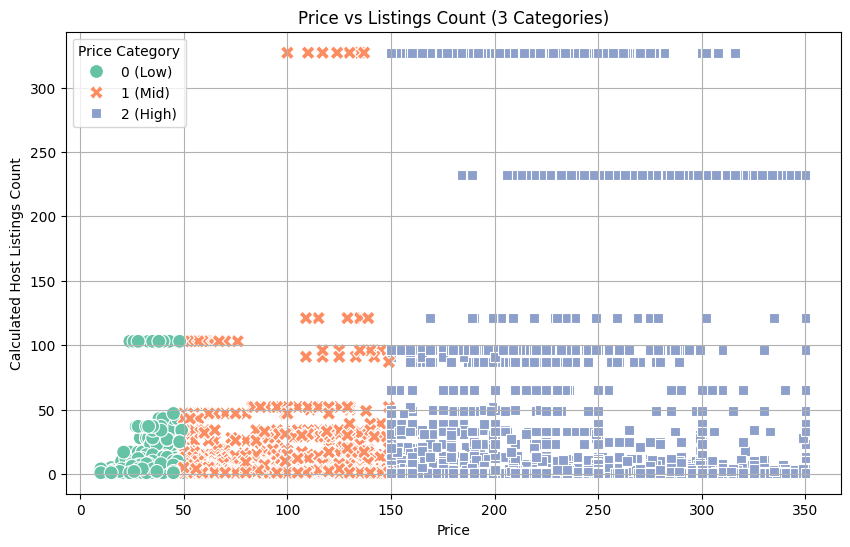

In [40]:
# Assuming 'price_category_index' is the column with three categories (0, 1, 2)
# You can modify this according to how your `price_category_index` is defined
airbnb_df = airbnb_df.withColumn("price_category_index",
  (col("price") < 50).cast("int") +
  ((col("price") >= 50) & (col("price") < 150)).cast("int") * 2 +
  (col("price") >= 150).cast("int") * 3)  #3 price categories

airbnb_df_selected = airbnb_df.select("price", "calculated_host_listings_count", "price_category_index")
airbnb_df_pd = airbnb_df_selected.toPandas()

plt.figure(figsize=(10, 6))

plot = sns.scatterplot(x='price', y='calculated_host_listings_count',
  hue='price_category_index', data=airbnb_df_pd, palette='Set2', style='price_category_index',s=100)

# Title and labels
plt.title('Price vs Listings Count (3 Categories)')
plt.ylabel('Calculated Host Listings Count')
plt.xlabel('Price')

# Modify the legend labels for three categories
handles, labels = plot.get_legend_handles_labels()
new_labels = ['0 (Low)', '1 (Mid)', '2 (High)']
plt.legend(handles, new_labels, title="Price Category")

# Grid for better visibility
plt.grid()

# Show the plot
plt.show()

In [41]:
ngrok.set_auth_token("2oZbulagUGA62MdYzkCfhqdsw0n_2TTXSs4Mf3DiqW6Er7z9h")
public_url = ngrok.connect(4040)
print("Ngrok tunnel \"{}\"".format(public_url))

Ngrok tunnel "NgrokTunnel: "https://adec-35-229-251-222.ngrok-free.app" -> "http://localhost:4040""
